In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [93]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(seed=12345)
from tqdm import tqdm

import agents
import users
import utils

importlib.reload(agents);
importlib.reload(users);
importlib.reload(utils);

In [3]:
def marginal_q_target(particles, num_targets, i=1):
    return np.histogram(particles['q'][:,i], bins=num_targets, range=(0, num_targets), weights=particles['w'], density=True)[0]

def marginal_q_f(particles, i=0, bins=10, range=(0,1) ):
    return np.histogram(particles['q'][:,i], bins=bins, range=range, weights=particles['w'], density=True)[0]

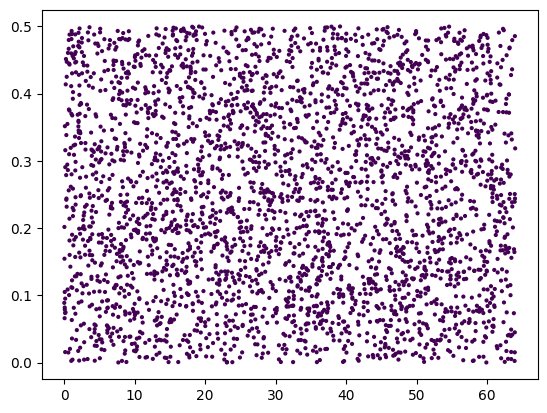

In [4]:
num_targets = 2**6

user = users.UserSimulator(target=4, f0=0.1, f1=0.1, rng=rng)
agent = agents.AInfAgentContinuous(model=users.UserModel(num_targets), 
                                   rng=rng,
                                   max_f=0.5,
                                   init_particles=None, #beliefs[-1],
                                   num_particles=3_200,
                                   planning_horizon=1,
                                   weight_info_gain=1.,
                                   select_optimal_plan=True)

oo_system = [agent.reset()]
beliefs = [agent.copy_particles()]
pragmatic_values = [agent.pragmatic.copy()]
info_gains = [agent.info_gain.copy()]
oo_user = []

agent.show_particles()

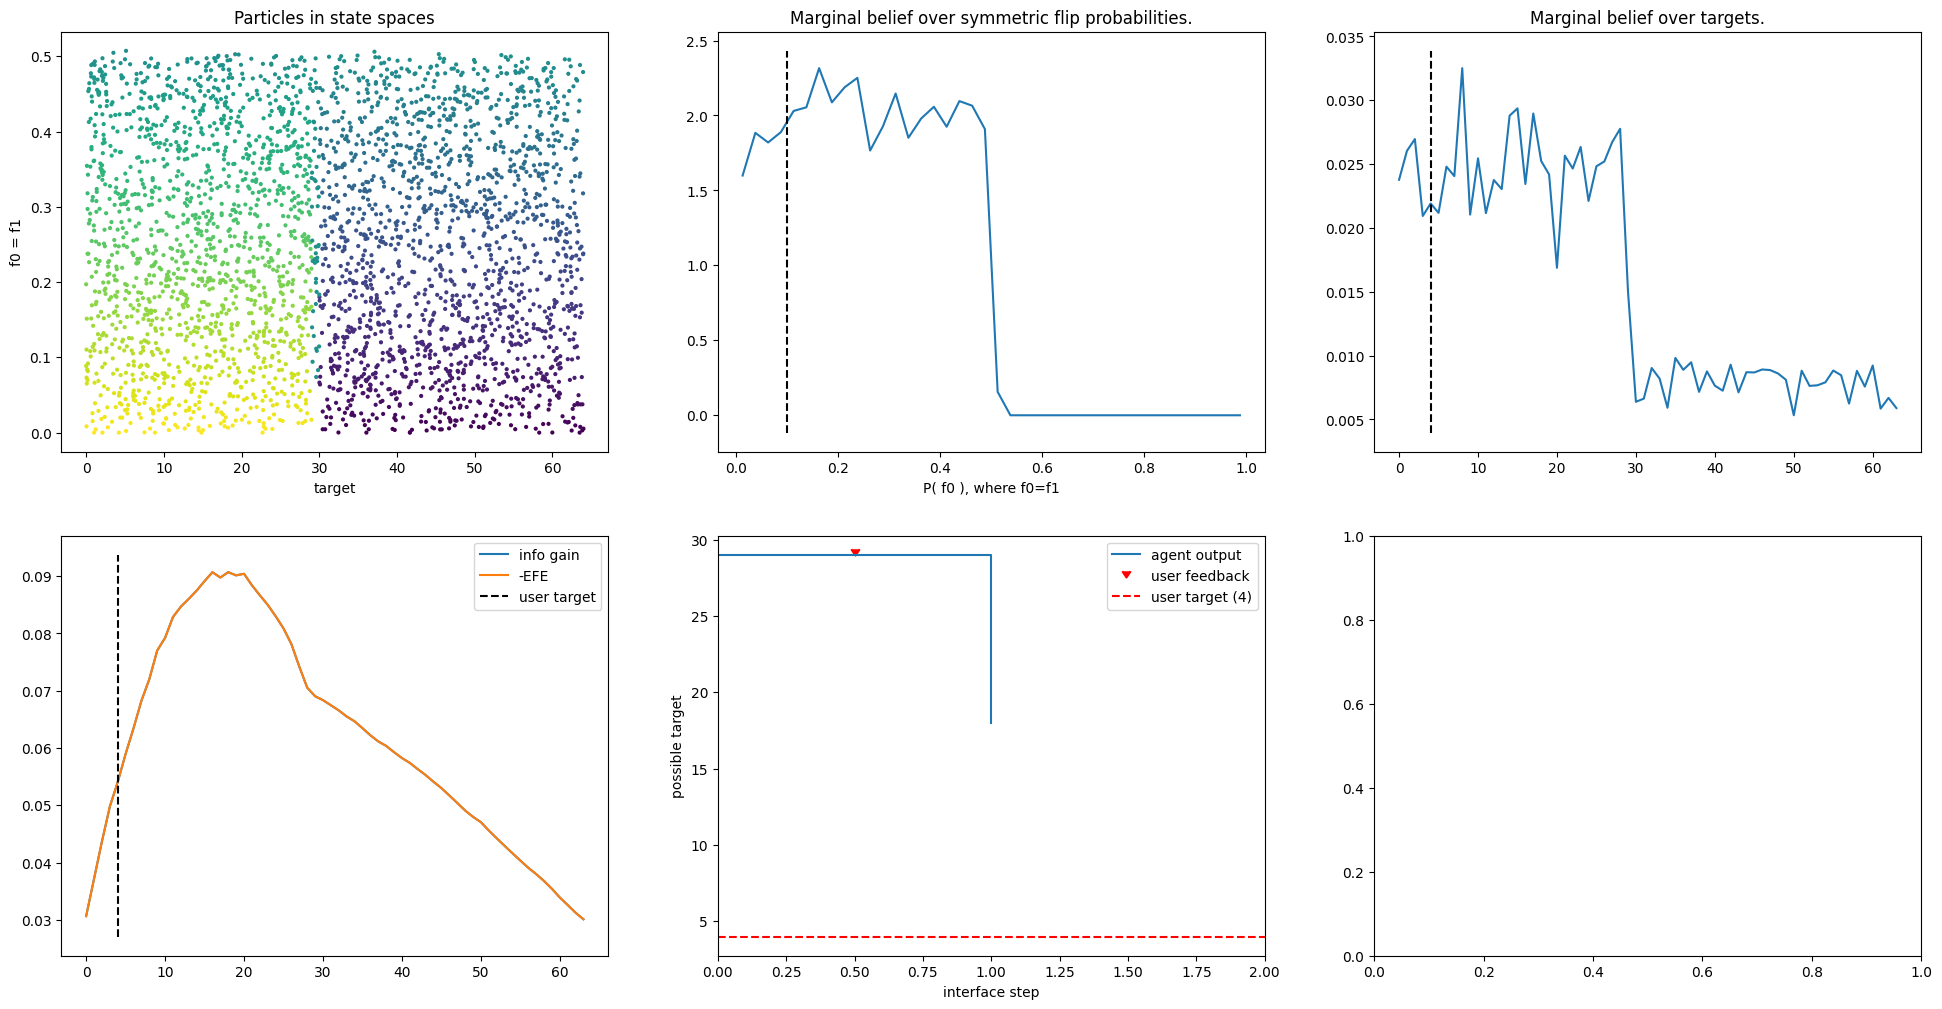

In [5]:
oo_user.append(user.step(oo_system[-1]))
oo_system.append(agent.step(oo_user[-1]))
beliefs.append(agent.copy_particles())
pragmatic_values.append(agent.pragmatic.copy())
info_gains.append(agent.info_gain.copy())

fig, axes = plt.subplots(2, 3, figsize=(3*8, 2*6) )

ax = axes[0][0]
agent.show_particles(ax=ax)
ax.set_title('Particles in state spaces');
ax.set_xlabel('target')
ax.set_ylabel('f0 = f1')
# TODO: add colorbar for particle weight

hist, limits = agent.marginal_q_flip(bins=40)
ax = axes[0][1]
ax.plot((limits[:-1] + limits[1:])/2, hist)
ax.plot([user.f0, user.f0], ax.get_ylim(), 'k--', label='user target')
ax.set_title('Marginal belief over symmetric flip probabilities.');
ax.set_xlabel('P( f0 ), where f0=f1')

ax = axes[0][2]
ax.plot(agent.marginal_q_target(agent.particles))
ax.plot([user.target, user.target], ax.get_ylim(), 'k--', label='user target')
ax.set_title('Marginal belief over targets.');

# axes[1][0].plot(agent.pragmatic, label='pragmatic')
axes[1][0].plot(agent.info_gain, label='info gain')
axes[1][0].plot(agent.nefe, label='-EFE')
ylim = axes[1][0].get_ylim()
axes[1][0].plot([user.target, user.target], ylim, 'k--', label='user target')
axes[1][0].legend()
utils.plot_interaction_sequence(oo_user, oo_system, user.target, ax=axes[1][1])

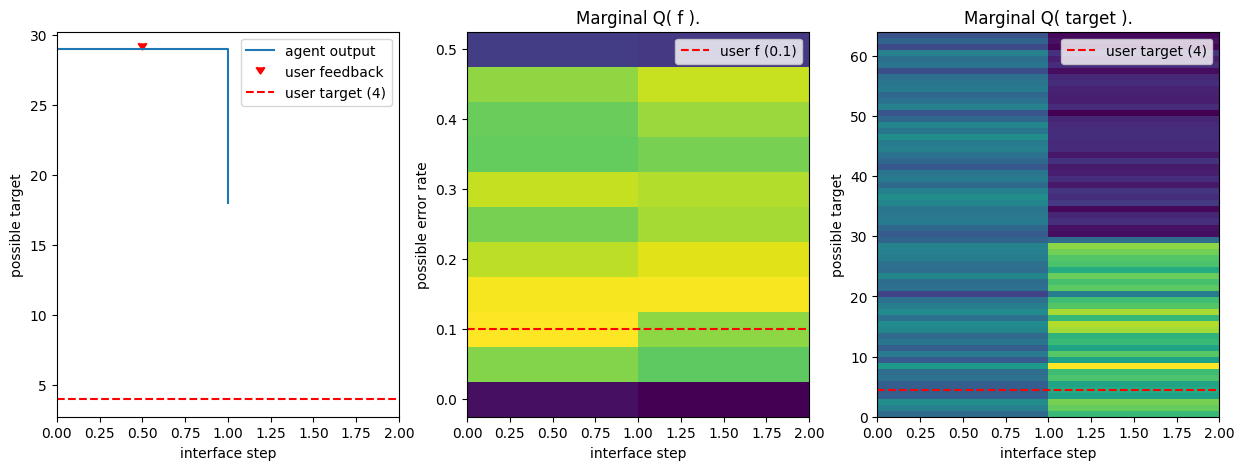

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
utils.plot_interaction_sequence(oo_user, oo_system, user.target, ax=axes[0])
q_target = np.asarray([marginal_q_target(particles=belief, num_targets=num_targets) for belief in beliefs])
utils.plot_target_belief_distribution_sequence(q_target, user.target, ax=axes[2])
bins = np.linspace(-0.025, 0.525, 12)
p_flip = np.asarray([marginal_q_f(particles=belief, bins=bins) for belief in beliefs])
utils.plot_f_belief_distribution_sequence(p_flip, user.f0, bins, ax=axes[1])

In [7]:
def run_experiment_ainf(num_targets, 
                        target, 
                        f0, 
                        f1, 
                        max_f, 
                        max_num_steps, 
                        num_particles, 
                        diffusion_scale_f,
                        diffusion_scale_target,
                        use_pragmatic_value, 
                        weight_info_gain,
                        init_particles=None):
    user = users.UserSimulator(target=target, f0=f0, f1=f1, rng=rng)
    
    # 1. test belief update
    agent = agents.AInfAgentContinuous(model=users.UserModel(num_targets), 
                                       rng=rng,
                                       max_f=max_f,
                                       init_particles=init_particles,
                                       num_particles=num_particles,
                                       diffusion_scale_f=diffusion_scale_f,
                                       diffusion_scale_target=diffusion_scale_target,
                                       planning_horizon=1,
                                       weight_info_gain=weight_info_gain,
                                       use_pragmatic_value=use_pragmatic_value,
                                       select_optimal_plan=True)
    
    oo_system = [agent.reset()]
    beliefs = [agent.copy_particles()]
    info_gains = [agent.info_gain.copy()]
    pragmatic_values = [agent.pragmatic.copy()]
    info_gains = [agent.info_gain.copy()]
    oo_user = []
    for _ in range(max_num_steps):
        
      oo_user.append(user.step(oo_system[-1]))
      oo_system.append(agent.step(oo_user[-1]))
      beliefs.append(agent.copy_particles())
      pragmatic_values.append(agent.pragmatic.copy())
      info_gains.append(agent.info_gain.copy())

    return oo_system, beliefs, pragmatic_values, info_gains, oo_user

In [87]:
def run_experiment_ainf_degrading(num_targets, 
                        target, 
                        f0, 
                        f1, 
                        f_inc, # sequence of additive change to (f0, f1) of shape (2, N), one array for each f, one element for each timestep
                        max_f, 
                        max_num_steps, 
                        num_particles, 
                        diffusion_scale_f,
                        diffusion_scale_target,
                        use_pragmatic_value, 
                        weight_info_gain,
                        init_particles=None):
    user = users.UserSimulator(target=target, f0=f0, f1=f1, rng=rng)
    
    # 1. test belief update
    agent = agents.AInfAgentContinuous(model=users.UserModel(num_targets), 
                                       rng=rng,
                                       max_f=max_f,
                                       init_particles=init_particles,
                                       num_particles=num_particles,
                                       diffusion_scale_f=diffusion_scale_f,
                                       diffusion_scale_target=diffusion_scale_target,
                                       planning_horizon=1,
                                       weight_info_gain=weight_info_gain,
                                       use_pragmatic_value=use_pragmatic_value,
                                       select_optimal_plan=True)
    
    oo_system = [agent.reset()]
    beliefs = [agent.copy_particles()]
    info_gains = [agent.info_gain.copy()]
    pragmatic_values = [agent.pragmatic.copy()]
    info_gains = [agent.info_gain.copy()]
    oo_user = []
    for i in range(max_num_steps):
      # modulate f
      user.f0 = f0 + f_inc[0,i]
      user.f1 = f1 + f_inc[1,i]
      oo_user.append(user.step(oo_system[-1]))
      oo_system.append(agent.step(oo_user[-1]))
      beliefs.append(agent.copy_particles())
      pragmatic_values.append(agent.pragmatic.copy())
      info_gains.append(agent.info_gain.copy())

    return oo_system, beliefs, pragmatic_values, info_gains, oo_user

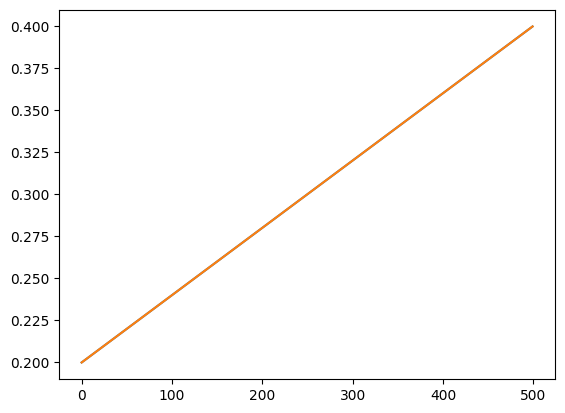

In [101]:

num_episodes = 5
num_steps = 100
num_steps_total = num_episodes * num_steps
f = np.ones((2, num_steps_total)) * 0.2
f_inc = np.arange(num_steps_total)/num_steps_total * 0.2
f_inc = np.vstack([f_inc, f_inc])
plt.plot( (f+f_inc).T )

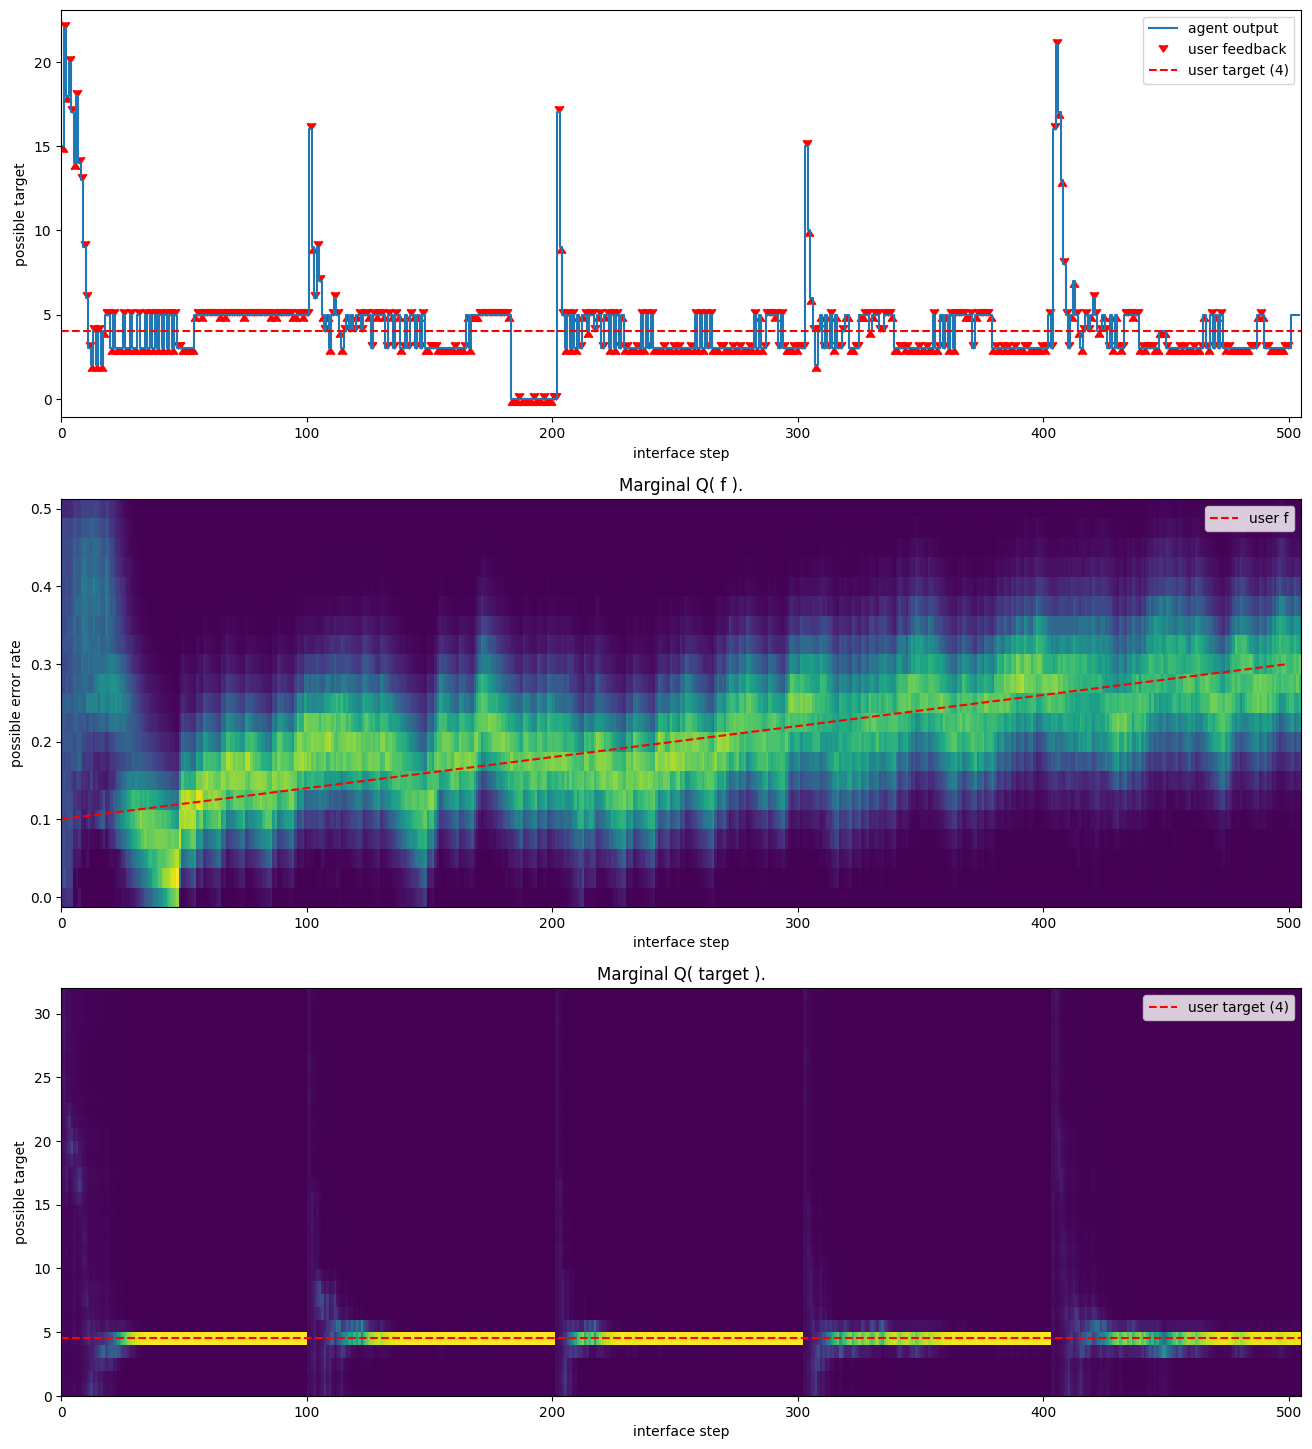

In [105]:
k = 5
num_targets = 2**k
config = {
    'num_targets': 2**5,
    'target': 4,
    'f0': 0.1,
    'f1': 0.1,
    'f_inc': f_inc,
    'max_f': 0.5,
    'max_num_steps': num_steps,
    'use_pragmatic_value': False,
    'weight_info_gain': 1.,
    'init_particles': None,
    'num_particles': 100 * num_targets, 
    'diffusion_scale_f': 0.01, 
    'diffusion_scale_target': 0}

oo_system, beliefs, oo_user = [], [], []
for j in range(num_episodes):
    if j > 0:
        config['init_particles'] = beliefs[-1]
        config['f_inc'] = f_inc[:,j*num_steps:]
        
    _oo_system, _beliefs, _pragmatic_values, _info_gains, _oo_user = run_experiment_ainf_degrading(**config)
    oo_system = np.concatenate((oo_system, _oo_system), axis=0)
    beliefs = np.concatenate((beliefs, _beliefs), axis=0)
    oo_user = np.concatenate((oo_user, _oo_user), axis=0)

fig, axes = plt.subplots(3, 1, figsize=(16, 3*6))
utils.plot_interaction_sequence(oo_user, oo_system, config['target'], ax=axes[0])
q_target = np.asarray([marginal_q_target(particles=belief, num_targets=config['num_targets']) for belief in beliefs])
utils.plot_target_belief_distribution_sequence(q_target, config['target'], ax=axes[2])

bins = np.linspace(-0.025, 1.025, 22) * config['max_f']
p_flip = np.asarray([marginal_q_f(particles=belief, bins=bins) for belief in beliefs])
utils.plot_f_belief_distribution_sequence(p_flip, np.asarray(config['f0']) + f_inc[0,:], bins, ax=axes[1])
# axes[1].plot( (np.array([config['f0'], config['f1']])[:,None] + f_inc).T )

In [107]:
# experiment 2

def run_experiment_series(mode, polarity):
    print("-------------------")
    print(mode, polarity)
    print("-------------------")

    num_episodes = 5
    use_pragmatic_value = False
    weight_info_gain = 1.
    
    # targets
    k = 5 # k=5: 32 symbols, k=8: 256 symbols
    num_targets = 2**k
    target = np.arange(num_targets)

    # particles
    num_particles = 100 * num_targets
    diffusion_scale_f = 0.01 # 0.005
    diffusion_scale_target = 0 # 0.1
    
    # user error rates
    num_f = 11
    if (polarity == "unknown_polarity"):
        max_f = 1.
    elif (polarity == "known_polarity"):
        max_f = 0.5
    else:
        print("ERROR unknown polarity", polarity)
        max_f = None
        
    f0 = np.linspace(0, max_f, num_f)
    f0 = f0[1:-1] # exclude minimum and maximum from explored range
    f0 = np.array([0.1])
    
    # repetitions
    num_repetitions = 10
    repetition = np.arange(num_repetitions)
    
    target, f0, repetition = np.meshgrid(target, f0, repetition)
    target = target.reshape(-1)
    f0 = f0.reshape(-1)
    repetition = repetition.reshape(-1)
    num_conditions = len(target)
    
    if (mode == "symmetric"):
        f1 = f0
    elif (mode == "fully_biased"):
        f1 = np.zeros_like(f0)
    else:
        print("ERROR: unknown mode", mode)
        f1 = None
    
    conditions = {'target': target, 'f0': f0, 'f1': f1}
    log = []
    for i in tqdm(range(num_conditions)):
        config = {'num_targets': num_targets, 
                  'target': target[i],
                  'f0': f0[i],
                  'f1': f1[i],
                  'f_inc': f_inc,
                  'max_f': max_f,
                  'num_particles': num_particles,
                  'diffusion_scale_f': diffusion_scale_f,
                  'diffusion_scale_target': diffusion_scale_target,
                  'use_pragmatic_value': use_pragmatic_value,
                  'weight_info_gain': weight_info_gain,
                  'max_num_steps': 20*k}

        if i == 0:
            print("first config")
            print(config)

        oo_system, beliefs, oo_user = [], [], []
        for j in range(num_episodes):
            if j > 0:
                config['init_particles'] = beliefs[-1]
                config['f_inc'] = f_inc[:,j*num_steps:]
                
            _oo_system, _beliefs, _pragmatic_values, _info_gains, _oo_user = run_experiment_ainf_degrading(**config)
            oo_system = np.concatenate((oo_system, _oo_system), axis=0)
            beliefs = np.concatenate((beliefs, _beliefs), axis=0)
            oo_user = np.concatenate((oo_user, _oo_user), axis=0)
            
        result = {'oo_system': oo_system, 'beliefs': beliefs, 'oo_user': oo_user}
        config['num_episodes'] = num_episodes
        config['init_particles'] = None
        log.append({'config': config, 'result': result})
    
    np.save(f'ainf_{num_targets}_{num_particles}_{mode}_{polarity}_{use_pragmatic_value}_{num_episodes}', [{'conditions': conditions, 'experiments': log}])
    print("DONE")

import itertools
for mode, polarity in itertools.product(["symmetric"], ["unknown_polarity", "known_polarity"]):
#for mode, polarity in itertools.product(["symmetric"], ["known_polarity"]):
    run_experiment_series(mode, polarity)

-------------------
symmetric unknown_polarity
-------------------


  0%|          | 0/320 [00:00<?, ?it/s]

first config
{'num_targets': 32, 'target': 0, 'f0': 0.1, 'f1': 0.1, 'f_inc': array([[0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.0116, 0.012 , 0.0124,
        0.0128, 0.0132, 0.0136, 0.014 , 0.0144, 0.0148, 0.0152, 0.0156,
        0.016 , 0.0164, 0.0168, 0.0172, 0.0176, 0.018 , 0.0184, 0.0188,
        0.0192, 0.0196, 0.02  , 0.0204, 0.0208, 0.0212, 0.0216, 0.022 ,
        0.0224, 0.0228, 0.0232, 0.0236, 0.024 , 0.0244, 0.0248, 0.0252,
        0.0256, 0.026 , 0.0264, 0.0268, 0.0272, 0.0276, 0.028 , 0.0284,
        0.0288, 0.0292, 0.0296, 0.03  , 0.0304, 0.0308, 0.0312, 0.0316,
        0.032 , 0.0324, 0.0328, 0.0332, 0.0336, 0.034 , 0.0344, 0.0348,
        0.0352, 0.0356, 0.036 , 0.0364, 0.0368, 0.0372, 0.0376, 0.038 ,
        0.0384, 0.0388, 0.0392, 0.0396, 0.04  , 0.0404, 0.0

100%|██████████| 320/320 [11:54<00:00,  2.23s/it]


DONE
-------------------
symmetric known_polarity
-------------------


  0%|          | 0/320 [00:00<?, ?it/s]

first config
{'num_targets': 32, 'target': 0, 'f0': 0.1, 'f1': 0.1, 'f_inc': array([[0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.0116, 0.012 , 0.0124,
        0.0128, 0.0132, 0.0136, 0.014 , 0.0144, 0.0148, 0.0152, 0.0156,
        0.016 , 0.0164, 0.0168, 0.0172, 0.0176, 0.018 , 0.0184, 0.0188,
        0.0192, 0.0196, 0.02  , 0.0204, 0.0208, 0.0212, 0.0216, 0.022 ,
        0.0224, 0.0228, 0.0232, 0.0236, 0.024 , 0.0244, 0.0248, 0.0252,
        0.0256, 0.026 , 0.0264, 0.0268, 0.0272, 0.0276, 0.028 , 0.0284,
        0.0288, 0.0292, 0.0296, 0.03  , 0.0304, 0.0308, 0.0312, 0.0316,
        0.032 , 0.0324, 0.0328, 0.0332, 0.0336, 0.034 , 0.0344, 0.0348,
        0.0352, 0.0356, 0.036 , 0.0364, 0.0368, 0.0372, 0.0376, 0.038 ,
        0.0384, 0.0388, 0.0392, 0.0396, 0.04  , 0.0404, 0.0

 72%|███████▏  | 231/320 [08:37<03:19,  2.24s/it]


KeyboardInterrupt: 

In [96]:
# experiment 1

def run_experiment_series(mode, polarity):
    print("-------------------")
    print(mode, polarity)
    print("-------------------")

    num_episodes = 5
    use_pragmatic_value = False
    weight_info_gain = 1.
    
    # targets
    k = 5 # k=5: 32 symbols, k=8: 256 symbols
    num_targets = 2**k
    target = np.arange(num_targets)

    # particles
    num_particles = 100 * num_targets
    diffusion_scale_f = 0.001 # 0.005
    diffusion_scale_target = 0 # 0.1
    
    # user error rates
    num_f = 11
    if (polarity == "unknown_polarity"):
        max_f = 1.
    elif (polarity == "known_polarity"):
        max_f = 0.5
    else:
        print("ERROR unknown polarity", polarity)
        max_f = None
        
    f0 = np.linspace(0, max_f, num_f)
    f0 = f0[1:-1] # exclude minimum and maximum from explored range
    f0 = np.array([0.3])
    
    # repetitions
    num_repetitions = 10
    repetition = np.arange(num_repetitions)
    
    target, f0, repetition = np.meshgrid(target, f0, repetition)
    target = target.reshape(-1)
    f0 = f0.reshape(-1)
    repetition = repetition.reshape(-1)
    num_conditions = len(target)
    
    if (mode == "symmetric"):
        f1 = f0
    elif (mode == "fully_biased"):
        f1 = np.zeros_like(f0)
    else:
        print("ERROR: unknown mode", mode)
        f1 = None
    
    conditions = {'target': target, 'f0': f0, 'f1': f1}
    log = []
    for i in tqdm(range(num_conditions)):
        config = {'num_targets': num_targets, 
                  'target': target[i],
                  'f0': f0[i],
                  'f1': f1[i],
                  'max_f': max_f,
                  'num_particles': num_particles,
                  'diffusion_scale_f': diffusion_scale_f,
                  'diffusion_scale_target': diffusion_scale_target,
                  'use_pragmatic_value': use_pragmatic_value,
                  'weight_info_gain': weight_info_gain,
                  'max_num_steps': 20*k}

        if i == 0:
            print("first config")
            print(config)

        oo_system, beliefs, oo_user = [], [], []
        for j in range(num_episodes):
            if j > 0:
                config['init_particles'] = beliefs[-1]
                
            _oo_system, _beliefs, _pragmatic_values, _info_gains, _oo_user = run_experiment_ainf(**config)
            oo_system = np.concatenate((oo_system, _oo_system), axis=0)
            beliefs = np.concatenate((beliefs, _beliefs), axis=0)
            oo_user = np.concatenate((oo_user, _oo_user), axis=0)
            
        result = {'oo_system': oo_system, 'beliefs': beliefs, 'oo_user': oo_user}
        config['num_episodes'] = num_episodes
        config['init_particles'] = None
        log.append({'config': config, 'result': result})
    
    np.save(f'ainf_{num_targets}_{num_particles}_{mode}_{polarity}_{use_pragmatic_value}_{num_episodes}', [{'conditions': conditions, 'experiments': log}])
    print("DONE")

import itertools
for mode, polarity in itertools.product(["symmetric"], ["unknown_polarity", "known_polarity"]):
#for mode, polarity in itertools.product(["symmetric"], ["known_polarity"]):
    run_experiment_series(mode, polarity)

-------------------
symmetric unknown_polarity
-------------------


  0%|          | 0/320 [00:00<?, ?it/s]

first config
{'num_targets': 32, 'target': 0, 'f0': 0.3, 'f1': 0.3, 'max_f': 1.0, 'num_particles': 3200, 'diffusion_scale_f': 0.001, 'diffusion_scale_target': 0, 'use_pragmatic_value': False, 'weight_info_gain': 1.0, 'max_num_steps': 100}


  0%|          | 1/320 [00:02<14:16,  2.68s/it]


KeyboardInterrupt: 

In [12]:
plt.plot(self.pragmatic, label='new')
# plt.plot(self.pragmatic_old, label='old')
plt.plot(self.info_gain, label='IG')
plt.plot(self.nefe, label='nefe')
plt.legend()

NameError: name 'self' is not defined

In [ ]:
print("Hello")